ABIDA Youssef (p2024398)
VADUREL Benjamin (2000154)

# Projet GNN - Classification de noeuds

# Imports

In [1]:
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, root_mean_squared_error
from EarlyStopping import EarlyStopping
from GCNBayesianOptimizer import GCNBayesianOptimizer
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%load_ext tensorboard

torch.manual_seed(0)

In [2]:
%tensorboard --logdir runs

In [16]:
%autoreload 2
from GCN import GCN
from GCN_no_pooling import GCN_no_pooling
from GCN_var1 import GCN_var1
from GraphSage import GraphSage
from GCN_Course import GCN_Course

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [47]:
graph = nx.read_graphml('../data/airportsAndCoordAndPop.graphml.xml')
graph.nodes(data=True)

NodeDataView({'0': {'lon': -145.50972222222222, 'lat': -17.35388888888889, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Anaa'}, '1': {'lon': -140.95, 'lat': -18.066666666666666, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Hao Island'}, '2': {'lon': -149.6, 'lat': -17.55, 'population': 26357, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Papeete'}, '3': {'lon': -135.0, 'lat': -23.033333333333335, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Gambier Island'}, '4': {'lon': -143.65725, 'lat': -16.584888888888887, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Makemo'}, '5': {'lon': 174.79166666666666, 'lat': -37.00805555555556, 'population': 417910, 'country': 'NEW_ZEALAND', 'city_name': 'Auckland'}, '6': {'lon': -139.03333333333333, 'lat': -9.8, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Atuona'}, '7': {'lon': -151.75, 'lat': -16.45, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 

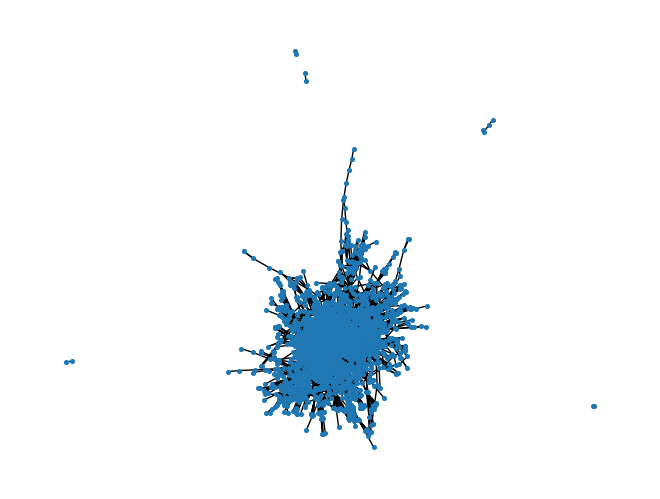

In [5]:
nx.draw(graph, with_labels=False, node_size=7)

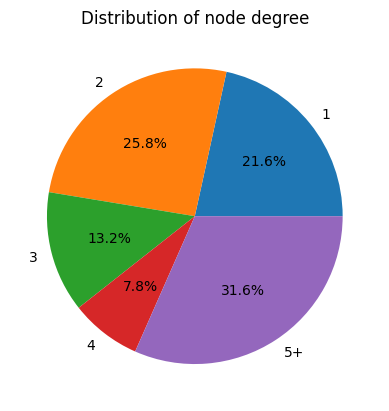

In [5]:
neighbors = {node: len(list(graph.neighbors(node))) for node in graph.nodes}

# Group nodes with 5 neighbors and more
grouped_neighbor_counts = [count if count < 5 else '5+' for count in neighbors.values()]
unique_grouped_counts = list(set(grouped_neighbor_counts))
grouped_count_frequencies = [grouped_neighbor_counts.count(count) for count in unique_grouped_counts]

# Plot the pie chart of the grouped number of neighbors
plt.pie(grouped_count_frequencies, labels=unique_grouped_counts, autopct='%1.1f%%')
plt.title('Distribution of node degree')
plt.show()

In [48]:
def remove_isolated_nodes(graph, min_degree=1):
    nodes_to_remove = [node for node in graph.nodes if graph.degree(node) < min_degree]
    graph.remove_nodes_from(nodes_to_remove)
    return graph

graph = remove_isolated_nodes(graph, min_degree=3)

In [39]:
graph.nodes

NodeView(('1', '2', '5', '7', '8', '9', '12', '13', '14', '15', '16', '18', '19', '20', '22', '25', '26', '28', '29', '30', '31', '32', '33', '34', '36', '37', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '59', '62', '64', '65', '66', '67', '68', '69', '70', '72', '73', '74', '76', '77', '78', '79', '81', '83', '84', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '141', '142', '143', '144', '145', '146', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '179', '180', '181', '

# Data description
 - lon : float
 - lat : float
 - population : int
 - country : string (exemple : 'FRENCH_POLYNESIA')
 - city_name : string (exemple : 'Anaa')

# Preprocessing

## Encoding du nom des villes

In [41]:
city_names = nx.get_node_attributes(graph, 'city_name')
print(city_names)

encoder = LabelEncoder()
print(city_names.values())
city_names_encoder = encoder.fit(list(city_names.values()))

for node in graph.nodes():
    graph.nodes[node]['city_name'] = city_names_encoder.transform([graph.nodes[node]['city_name']])[0]

graph.nodes(data=True)


{'0': 'Anaa', '1': 'Hao Island', '2': 'Papeete', '3': 'Gambier Island', '4': 'Makemo', '5': 'Auckland', '6': 'Atuona', '7': 'Bora Bora', '8': 'Honolulu', '9': 'Huahine', '10': 'Easter Island', '11': 'Kaukura Atoll', '12': 'Los Angeles', '13': 'Moorea', '14': 'Nuku Hiva', '15': 'Noumea', '16': 'Osaka', '17': 'Mataiva', '18': 'Rarotonga', '19': 'Raiatea Island', '20': 'Rangiroa Island', '21': 'Rurutu', '22': 'Tikehau Atoll', '23': 'Takaroa', '24': 'Tubuai', '25': 'Tokyo', '26': 'Wallis Island', '27': 'Manihi', '28': 'Apia', '29': 'Blenheim', '30': 'Brisbane', '31': 'Buenos Aires', '32': 'Christchurch', '33': 'Cairns', '34': 'Denpasar Bali', '35': 'Gisborne', '36': 'Hong Kong', '37': 'Hamilton', '38': 'Niue', '39': 'Kaitaia', '40': 'Kerikeri', '41': 'Kuala Lumpur', '42': 'Melbourne', '43': 'Nadi', '44': 'Nagoya', '45': 'Norfolk Island', '46': 'Napier-Hastings', '47': 'New Plymouth', '48': 'Nelson', '49': 'Perth', '50': 'Palmerston North', '51': 'Rotorua', '52': 'Seoul', '53': 'Singapore',

NodeDataView({'0': {'lon': -145.50972222222222, 'lat': -17.35388888888889, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': np.int64(99)}, '1': {'lon': -140.95, 'lat': -18.066666666666666, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': np.int64(1071)}, '2': {'lon': -149.6, 'lat': -17.55, 'population': 26357, 'country': 'FRENCH_POLYNESIA', 'city_name': np.int64(2207)}, '3': {'lon': -135.0, 'lat': -23.033333333333335, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': np.int64(920)}, '4': {'lon': -143.65725, 'lat': -16.584888888888887, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': np.int64(1705)}, '5': {'lon': 174.79166666666666, 'lat': -37.00805555555556, 'population': 417910, 'country': 'NEW_ZEALAND', 'city_name': np.int64(193)}, '6': {'lon': -139.03333333333333, 'lat': -9.8, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': np.int64(191)}, '7': {'lon': -151.75, 'lat': -16.45, 'population': 10000, 'countr

In [42]:
graph_data = from_networkx(graph, group_node_attrs=["lon","lat","city_name"])

print(graph_data)
print(graph_data.num_nodes)
print(graph_data.num_edges)
print(graph_data.num_node_features)

def get_data() :
    return graph_data.clone()

Data(edge_index=[2, 27094], country=[3363], x=[3363, 4])
3363
27094
4


In [43]:
# Preprocessing des données

data = get_data()

encoder = LabelEncoder()

country_encoder = encoder.fit(data.country)
data.country = encoder.transform(data.country)

In [44]:
target_tensor = torch.tensor(data.country, dtype=torch.long)
data.y = target_tensor
data.num_classes = len(set(data.country))

train_ratio = 0.8
val_ratio = 0.1

mask = torch.rand(data.num_nodes)
data.train_mask = mask < train_ratio
data.val_mask = (mask >= train_ratio) & (mask < train_ratio + val_ratio)
data.test_mask = mask >= train_ratio + val_ratio

temp = torch.zeros((data.num_nodes, graph_data.num_node_features), dtype=torch.float)
temp[data.train_mask] = data.x[data.train_mask]
data.x = temp


In [18]:
torch.manual_seed(0)

model = GCN_Course(data.x.shape[1], data.num_classes)
model = model.to(device)
data = data.to(device)

model.fit(data, 10000)

print(model.test_model(data))

(0.40512820512820513, np.float64(0.3542798995698193), np.float64(73.68536715884188))


# Base GCN

In [45]:
torch.manual_seed(0)

model = GCN(data.x.shape[1], data.num_classes,300)
data = data.to(device)
model = model.to(device)

model.fit(data,10000)

print(model.test_model(data))

(0.18100890207715134, np.float64(0.03276422263117576), np.float64(115.72447581506094))


# GCN without pooling

In [28]:
gcn_no_pooling = GCN_no_pooling(data.x.shape[1], data.num_classes, 150)
data = data.to(device)
gcn_no_pooling = gcn_no_pooling.to(device)

gcn_no_pooling.fit(data, 4000)

print(gcn_no_pooling.test_model(data))

(0.5538461538461539, np.float64(0.5100763568154872), np.float64(63.54166813787304))


In [24]:
gcn_no_pooling = GCN_no_pooling(data.x.shape[1], data.num_classes, 150)
gcn_no_pooling = gcn_no_pooling.to(device)


gcn_no_pooling = gcn_no_pooling.fit(data, 2000)


print(gcn_no_pooling.test_model(data))

(0.5948717948717949, np.float64(0.5289503089503089), np.float64(52.792384843231865))


# GCN tuning

In [29]:
data = data.to(device)

torch.manual_seed(0)

tuner = GCNBayesianOptimizer()

best = tuner.exec(10,data,GCN)

best.params

[I 2024-10-20 11:21:13,533] A new study created in memory with name: no-name-ba70aff5-6633-42fb-95e2-d383610892a2
[I 2024-10-20 11:21:24,274] Trial 0 finished with value: 0.41025641025641024 and parameters: {'lr': 0.04703201206661294, 'wd': 0.03133891239044449, 'nb_neuron': 208}. Best is trial 0 with value: 0.41025641025641024.
[I 2024-10-20 11:21:39,406] Trial 1 finished with value: 0.49230769230769234 and parameters: {'lr': 0.014029763312389882, 'wd': 0.0076767353113871084, 'nb_neuron': 112}. Best is trial 1 with value: 0.49230769230769234.
[I 2024-10-20 11:21:51,494] Trial 2 finished with value: 0.4666666666666667 and parameters: {'lr': 0.03265039952405397, 'wd': 0.04316027957787351, 'nb_neuron': 325}. Best is trial 1 with value: 0.49230769230769234.
[I 2024-10-20 11:22:02,613] Trial 3 finished with value: 0.041025641025641026 and parameters: {'lr': 0.07974211600576851, 'wd': 0.02662800140971292, 'nb_neuron': 389}. Best is trial 1 with value: 0.49230769230769234.
[I 2024-10-20 11:22

{'lr': 0.014029763312389882, 'wd': 0.0076767353113871084, 'nb_neuron': 112}

In [38]:
sage = GraphSage(data.x.shape[1], data.num_classes, 600)

sage = sage.to(device)

data = data.to(device)

sage = sage.fit(data, 8000)

print(sage.test_model(data))

(0.18100890207715134, np.float64(0.03276422263117576), np.float64(115.72447581506094))
